# Pipeline example with OpenVINO inference execution engine 

This notebook illustrates how you can serve ensemble of models using [OpenVINO prediction model](https://github.com/SeldonIO/seldon-core/tree/master/wrappers/s2i/python_openvino).
The demo includes optimized ResNet50 and DenseNet169 models by OpenVINO model optimizer. 
They have [reduced precision](https://www.intel.ai/introducing-int8-quantization-for-fast-cpu-inference-using-openvino/#gs.lUSgiWKa) of graph operations from FP32 to INT8. It significantly improves the execution peformance with minimal impact on the accuracy. The gain is particulary visible with the latest Casade Lake CPU with [VNNI](https://www.intel.ai/intel-deep-learning-boost/#gs.sy7JEtwu) extension.

![pipeline](pipeline1.png)

## Install Seldon Core on Minikube or on any Kubernetes cluster

**The Minikube example below assumes version 0.30.0 installed**

It also assumes;
  * You have 4G of memory available
  * You have 4 CPU Cores available
  * You have 20G of free disk
  
**If you already have Kubernetes cluster present, you can skip minikube setup steps**

In [25]:
!minikube start --memory 4096 --cpus 4 --disk-size 20g

Starting local Kubernetes v1.13.2 cluster...
Starting VM...
Getting VM IP address...
Moving files into cluster...
Setting up certs...
Connecting to cluster...
Setting up kubeconfig...
Stopping extra container runtimes...
Starting cluster components...
Verifying kubelet health ...
Verifying apiserver health ...
Kubectl is now configured to use the cluster.
Loading cached images from config file.


Everything looks great. Please enjoy minikube!


## Setup Seldon Core

Follow the instructions to [Setup Cluster](../../seldon_core_setup.ipynb#Setup-Cluster) with [Ambassador Ingress](../../seldon_core_setup.ipynb#Ambassador) and [Install Seldon Core](../../seldon_core_setup.ipynb#Install-Seldon-Core).

## (Optional) Install Jaeger

We will use the Jaeger All-in-1 resource found at the [Jaeger Kubernetes repo](https://github.com/jaegertracing/jaeger-kubernetes).

In [6]:
!kubectl create -f https://raw.githubusercontent.com/jaegertracing/jaeger-kubernetes/master/all-in-one/jaeger-all-in-one-template.yml -n seldon

deployment.extensions/jaeger created
service/jaeger-query created
service/jaeger-collector created
service/jaeger-agent created
service/zipkin created


### Start Jaeger UI

```
minikube service jaeger-query -n seldon
```

## (Optional) Build Model, Combiner and Transformer Images
This is optional step. You can skip building the docker images for the pipeline components and rely on the prebuilt versions in the public docker registry. 

The commands below build the components on the docker registry inside the minikube.

Alternatively you can change the REGISTRY variable to your private one and drop the `eval $(minikube docker-env) &&` phrase. In that case, after the images are built, you need to push them to your docker registry and update the images names in the pipeline json file.

In [4]:
%env REGISTRY=docker.io/seldonio

env: REGISTRY=docker.io/seldonio


In [18]:
!eval $(minikube docker-env) && cd resources/model && s2i build -E environment_grpc . ${REGISTRY}/seldon-core-s2i-openvino:0.1 ${REGISTRY}/seldon-openvino-prediction:0.1

---> Installing application source...
---> Installing dependencies ...
Looking in links: /whl
  Url '/whl' is ignored. It is either a non-existing path or lacks a specific scheme.
  Url '/whl' is ignored. It is either a non-existing path or lacks a specific scheme.
  Url '/whl' is ignored. It is either a non-existing path or lacks a specific scheme.
  Url '/whl' is ignored. It is either a non-existing path or lacks a specific scheme.
  Url '/whl' is ignored. It is either a non-existing path or lacks a specific scheme.
  Url '/whl' is ignored. It is either a non-existing path or lacks a specific scheme.
  Url '/whl' is ignored. It is either a non-existing path or lacks a specific scheme.
  Url '/whl' is ignored. It is either a non-existing path or lacks a specific scheme.
  Url '/whl' is ignored. It is either a non-existing path or lacks a specific scheme.
  Url '/whl' is ignored. It is either a non-existing path or lacks a specific scheme.
  Url '/whl' is ignored. It is either a non-ex

Successfully built googleapis-common-protos
You are using pip version 10.0.1, however version 19.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Build completed successfully


In [11]:
!eval $(minikube docker-env) && cd resources/combiner && s2i build -E environment_grpc . ${REGISTRY}/seldon-core-s2i-openvino:0.1 ${REGISTRY}/imagenet_combiner:0.1

---> Installing application source...
Build completed successfully


In [12]:
!eval $(minikube docker-env) && cd resources/transformer && s2i build -E environment_grpc . ${REGISTRY}/seldon-core-s2i-openvino:0.1 ${REGISTRY}/imagenet_transformer:0.1

---> Installing application source...
---> Installing dependencies ...
Looking in links: /whl
You are using pip version 10.0.1, however version 19.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Build completed successfully


## Deploy Seldon pipeline with Intel OpenVINO models ensemble

 * Ingest compressed JPEG binary and transform to TensorFlow Proto payload
 * Ensemble two OpenVINO optimized models for ImageNet classification: ResNet50, DenseNet169
 * Return result in human readable text



In [7]:
!pip install graphviz
import sys
sys.path.append("../../../notebooks")
from visualizer import *

You are using pip version 19.0.3, however version 19.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


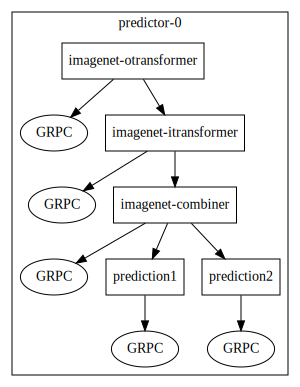

In [8]:
get_graph("seldon_ov_predict_ensemble.json")

In [9]:
!pygmentize seldon_ov_predict_ensemble.json

{
  "apiVersion": "machinelearning.seldon.io/v1alpha2",
  "kind": "SeldonDeployment",
  "metadata": {
    "labels": {
      "app": "seldon"
    },
    "name": "openvino-model",
    "namespace": "seldon"
  },
    "spec": {
	"annotations" : {
	    "seldon.io/grpc-read-timeout":"100000"
	},
    "name": "openvino",
    "predictors": [
      {
        "componentSpecs": [{
          "spec": {
            "containers": [
              {
                "name": "imagenet-itransformer",
                "image": "seldonio/openvino-demo-transformer:0.1",
                "env": [
                  {
                    "name": "TRACING",
                    "value": "1"
                  },
                  {
                    "name": "JAEGER_AGENT_HOST",
                    "value": "jaeger-agent"
                  },
                  {
                    "name": "DTYPE",
                    "value": "float32"
                  }
                ]
              },
              {
           

In [10]:
!kubectl apply -f seldon_ov_predict_ensemble.json

seldondeployment.machinelearning.seldon.io/openvino-model created


## Executing the pipeline

### Connectivity with the seldon pipeline

You may connect to the seldon ambassador endpoint using on of the following options:
- Establish a tunnel over http via `kubectl port-forward` command.

Expose ambassador API endpoint outside of the Kubernetes cluster or connect to it via `kubectl port-forward`.

```
kubectl port-forward $(kubectl get pods -n seldon -l app.kubernetes.io/name=ambassador -o jsonpath='{.items[0].metadata.name}') -n seldon 8080:8080
```
- Expose the service `seldon-core-ambassador` using a `LoadBalancer` or `NodePort` type.

```kubectl edit service seldon-core-ambassador```

Check the assigned External IP address with:

```kubectl get service seldon-core-ambassador```


### Using the exemplary grpc client

Install client dependencies: seldon-core and grpcio packages

In [11]:
!pip install -q seldon-core grpcio

You are using pip version 19.0.3, however version 19.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [12]:
!python seldon_grpc_client.py --debug

meta {
  puid: "meabbkemsugfo0vc84j7vc19us"
  routing {
    key: "imagenet-combiner"
    value: -1
  }
  routing {
    key: "imagenet-itransformer"
    value: -1
  }
  routing {
    key: "imagenet-otransformer"
    value: -1
  }
  requestPath {
    key: "imagenet-combiner"
    value: "seldonio/openvino-demo-combiner:0.1"
  }
  requestPath {
    key: "imagenet-itransformer"
    value: "seldonio/openvino-demo-transformer:0.1"
  }
  requestPath {
    key: "imagenet-otransformer"
    value: "seldonio/openvino-demo-transformer:0.1"
  }
  requestPath {
    key: "prediction1"
    value: "seldonio/openvino-demo-prediction:0.1"
  }
  requestPath {
    key: "prediction2"
    value: "seldonio/openvino-demo-prediction:0.1"
  }
}
strData: "Eskimo dog, husky"

Duration 8459.775 ms
meta {
  puid: "3l9jq1tm0c5lu00gp476hca9bd"
  routing {
    key: "imagenet-combiner"
    value: -1
  }
  routing {
    key: "imagenet-itransformer"
    value: -1
  }
  routing {
    key: "imagenet-otransformer"
    value: 

For more extensive test see the client help.

You can change the default test-input file including labeled list of images to calculate accuracy based on complete imagenet dataset. Follow the format from file `input_images.txt` - path to the image and imagenet class in every line.

In [28]:
!python seldon_grpc_client.py --help

usage: seldon_grpc_client.py [-h] [--repeats REPEATS] [--debug]
                             [--test-input TEST_INPUT]

optional arguments:
  -h, --help            show this help message and exit
  --repeats REPEATS
  --debug
  --test-input TEST_INPUT


## Examining the logs

You can use Seldon containers logs to get additional details about the execution:


In [2]:
!kubectl logs $(kubectl get pods -l seldon-app=openvino -o jsonpath='{.items[0].metadata.name}') prediction1 --tail=10

2019-02-12 10:32:38,646 - Prediction - DEBUG - Processing time: 27.29 ms
2019-02-12 10:32:38,646 - Prediction:predict:103 - DEBUG:  Processing time: 27.29 ms
2019-02-12 10:32:38,699 - Prediction - DEBUG - Processing time: 26.76 ms
2019-02-12 10:32:38,699 - Prediction:predict:103 - DEBUG:  Processing time: 26.76 ms
2019-02-12 10:37:59,123 - Prediction - DEBUG - Processing time: 27.28 ms
2019-02-12 10:37:59,123 - Prediction:predict:103 - DEBUG:  Processing time: 27.28 ms
2019-02-12 10:37:59,174 - Prediction - DEBUG - Processing time: 26.20 ms
2019-02-12 10:37:59,174 - Prediction:predict:103 - DEBUG:  Processing time: 26.20 ms
2019-02-12 10:37:59,228 - Prediction - DEBUG - Processing time: 27.33 ms
2019-02-12 10:37:59,228 - Prediction:predict:103 - DEBUG:  Processing time: 27.33 ms


In [3]:
!kubectl logs $(kubectl get pods -l seldon-app=openvino -o jsonpath='{.items[0].metadata.name}') prediction2 --tail=10

2019-02-12 10:32:38,630 - Prediction - DEBUG - Processing time: 9.86 ms
2019-02-12 10:32:38,630 - Prediction:predict:103 - DEBUG:  Processing time: 9.86 ms
2019-02-12 10:32:38,681 - Prediction - DEBUG - Processing time: 9.32 ms
2019-02-12 10:32:38,681 - Prediction:predict:103 - DEBUG:  Processing time: 9.32 ms
2019-02-12 10:37:59,111 - Prediction - DEBUG - Processing time: 15.16 ms
2019-02-12 10:37:59,111 - Prediction:predict:103 - DEBUG:  Processing time: 15.16 ms
2019-02-12 10:37:59,158 - Prediction - DEBUG - Processing time: 9.16 ms
2019-02-12 10:37:59,158 - Prediction:predict:103 - DEBUG:  Processing time: 9.16 ms
2019-02-12 10:37:59,211 - Prediction - DEBUG - Processing time: 9.62 ms
2019-02-12 10:37:59,211 - Prediction:predict:103 - DEBUG:  Processing time: 9.62 ms


In [4]:
!kubectl logs $(kubectl get pods -l seldon-app=openvino -o jsonpath='{.items[0].metadata.name}') imagenet-itransformer --tail=10

2019-02-12 10:37:59,086 - ImageNetTransformer:transform_input_grpc:43 - INFO:  jpeg preprocessing: 1.464 ms
2019-02-12 10:37:59,089 - ImageNetTransformer:transform_input_grpc:50 - INFO:  Total transformation: 4.042 ms
2019-02-12 10:37:59,137 - ImageNetTransformer:transform_input_grpc:33 - INFO:  Transform called
2019-02-12 10:37:59,139 - ImageNetTransformer:transform_input_grpc:40 - INFO:  Shape: (1, 3, 224, 224); Dtype: float32; Min: 0.0; Max: 255.0
2019-02-12 10:37:59,140 - ImageNetTransformer:transform_input_grpc:43 - INFO:  jpeg preprocessing: 2.222 ms
2019-02-12 10:37:59,142 - ImageNetTransformer:transform_input_grpc:50 - INFO:  Total transformation: 4.92 ms
2019-02-12 10:37:59,188 - ImageNetTransformer:transform_input_grpc:33 - INFO:  Transform called
2019-02-12 10:37:59,191 - ImageNetTransformer:transform_input_grpc:40 - INFO:  Shape: (1, 3, 224, 224); Dtype: float32; Min: 0.0; Max: 255.0
2019-02-12 10:37:59,191 - ImageNetTransformer:transform_input_grpc:43 - INFO:  jpeg preproc

## Performance consideration

In production environment with a shared workloads, you might consider contraining the CPU resources for individual pipeline components. You might restrict the assigned capacity using [Kubernetes capabilities](https://kubernetes.io/docs/concepts/configuration/manage-compute-resources-container/). This configuration can be added to seldon pipeline definition.

Another option for tuning the resource allocation is adding environment variable `OMP_NUM_THREADS`. It can indicate how many threads will be used by OpenVINO execution engine and how many CPU cores can be consumed. The recommeded value is equal to the number of allocated CPU physical cores.

In the tests using GKE service in Google Cloud on nodes with 32 SkyLake vCPU assigned, the following configuration was set on prediction components. It achieved the optimal latency and throughput:
```
"resources": {
  "requests": {
     "cpu": "1"
  },
  "limits": {
     "cpu": "32"
  }
}

"env": [
  {
    "name": "KMP_AFFINITY",
    "value": "granularity=fine,verbose,compact,1,0"
  },
  {
    "name": "KMP_BLOCKTIME",
    "value": "1"
  },
  {
    "name": "OMP_NUM_THREADS",
    "value": "8"
  }
]
```